# SST Reliability

<div>
    <p style="float: left;"><img src="images/fruit_game.png" alt="Drawing" style="width: 200px; border-right:10px solid white"/> 
    <p>Here, we compare the reliability of the aggretation method to calculate SSTs and methods using trial-level analyses.</p>
</div>


In [ ]:
# Running the init notebook
import dotenv
import pytest
init_notebook_path = dotenv.dotenv_values()['INIT_NOTEBOOK_PATH']
%run $init_notebook_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# We're only working with the initial data
from wp1 import stats, data_provider as dp

In [ ]:
def get_session_data():
    session_data = dp.get_gbe_baseline_data(columns = ['participant','baseline_session'])
    df = session_data.merge(dp.load_interim('initial_baseline_sst_scores'), left_index = True, right_index = True, how='inner')
    return df

sst_data_getter = dp.get_initial_ssrt_data


# Internal consistency (split-half reliability)

In [ ]:
get_session_data().columns

Index(['participant', 'baseline_session', 'ssrt_mean_method',
       'ssrt_integration_without_replacement', 'ssrt_predicted'],
      dtype='object')

In [ ]:
#os_mean = stats.analyze_split_half(bs, "mean_oversampling_even", "mean_oversampling_uneven", add_jitter = True)

# Test-retest reliability

### Integration without replacement (gold standard; ToDo: change to integration with replacement)

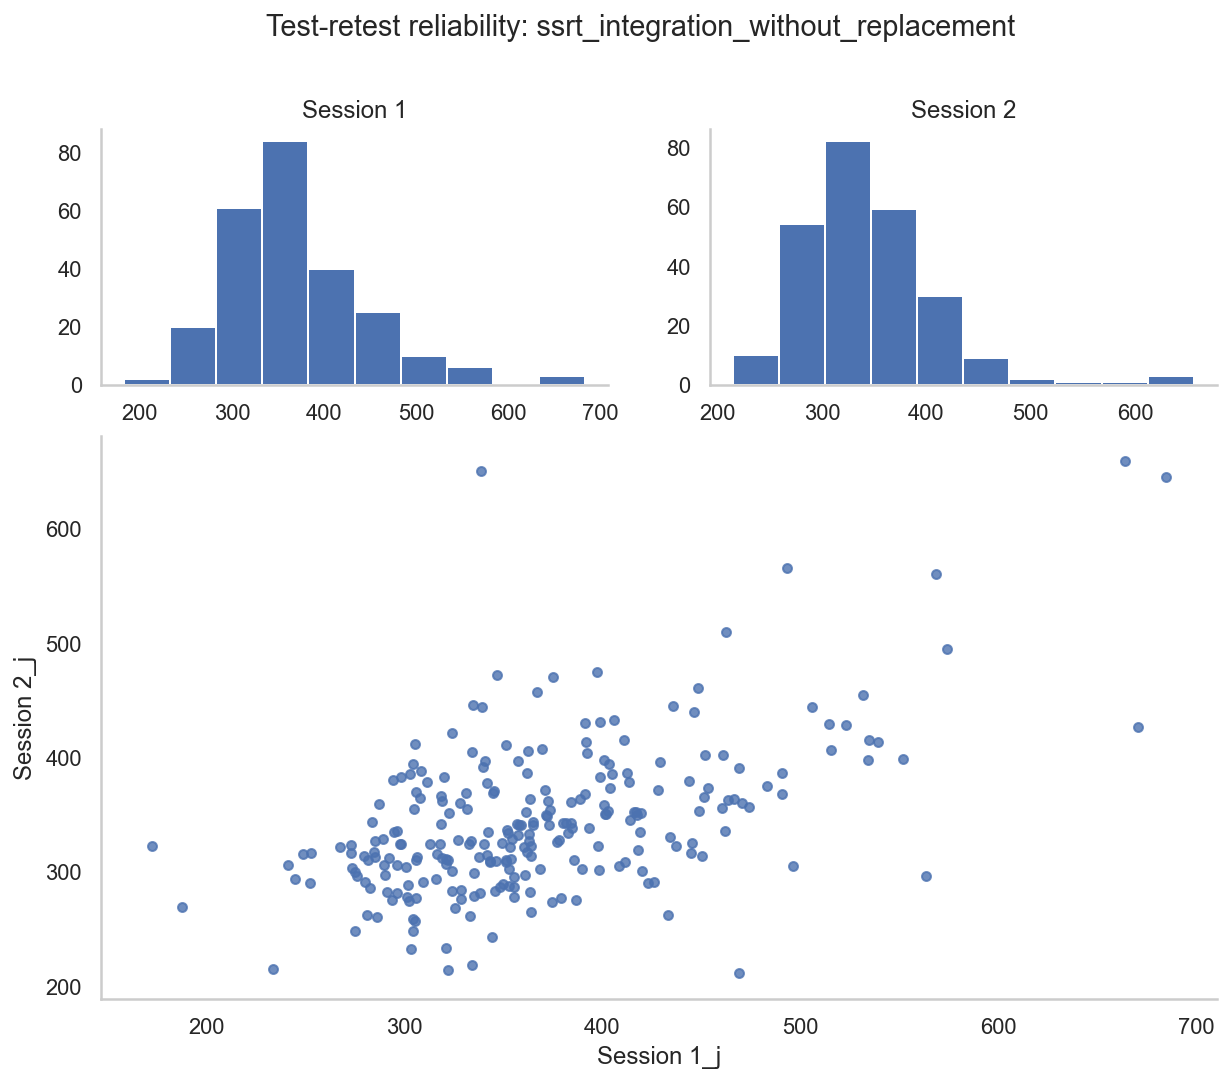

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
0,ICC1,0.667,9.016,250.0,753.0,0.0,0.624,0.709,".67 (.62, .71)"
1,ICC2,0.670,10.035,250.0,750.0,0.0,0.616,0.719,".67 (.62, .72)"
2,ICC3,0.693,10.035,250.0,750.0,0.0,0.652,0.732,".69 (.65, .73)"
3,ICC1k,0.889,9.016,250.0,753.0,0.0,0.869,0.907,".89 (.87, .91)"
4,ICC2k,0.890,10.035,250.0,750.0,0.0,0.865,0.911,".89 (.87, .91)"
5,ICC3k,0.900,10.035,250.0,750.0,0.0,0.882,0.916,".90 (.88, .92)"


,type,variance,Percent
0,Participant,3571.517,0.670
1,Session,178.756,0.034
2,Residual,1581.183,0.297
3,Total,5331.456,1.000


In [ ]:
stats = reload(stats)
iccs_mean = stats.analyze_reliability(get_session_data(), "ssrt_integration_without_replacement", add_jitter = True)

The task's reliability is ? to ? (based on confidence intervals and according to criteria by Koo and Li, 2016).

## Trial-level analysis (sessions modelled separately)

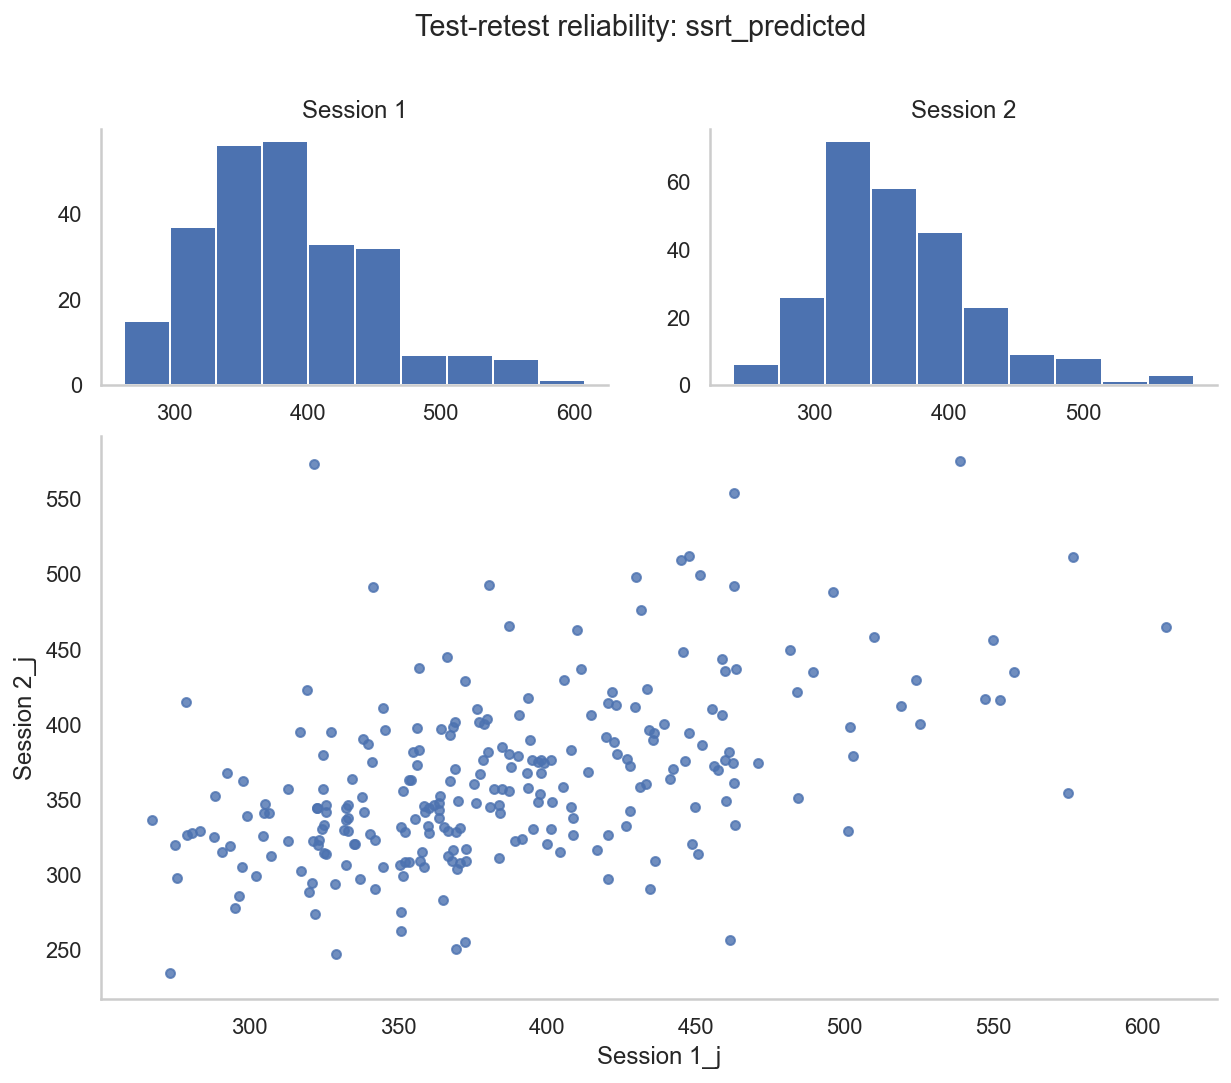

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
0,ICC1,0.638,8.044,250.0,753.0,0.0,0.592,0.682,".64 (.59, .68)"
1,ICC2,0.642,9.137,250.0,750.0,0.0,0.581,0.696,".64 (.58, .70)"
2,ICC3,0.670,9.137,250.0,750.0,0.0,0.628,0.712,".67 (.63, .71)"
3,ICC1k,0.876,8.044,250.0,753.0,0.0,0.853,0.896,".88 (.85, .90)"
4,ICC2k,0.878,9.137,250.0,750.0,0.0,0.847,0.901,".88 (.85, .90)"
5,ICC3k,0.891,9.137,250.0,750.0,0.0,0.871,0.908,".89 (.87, .91)"


,type,variance,Percent
0,Participant,2447.201,0.642
1,Session,163.448,0.043
2,Residual,1203.068,0.315
3,Total,3813.718,1.000


In [ ]:
stats = reload(stats)
iccs_mean = stats.analyze_reliability(get_session_data(), "ssrt_predicted", add_jitter = True)

# Trial level analysis (sessions modeled jointly)

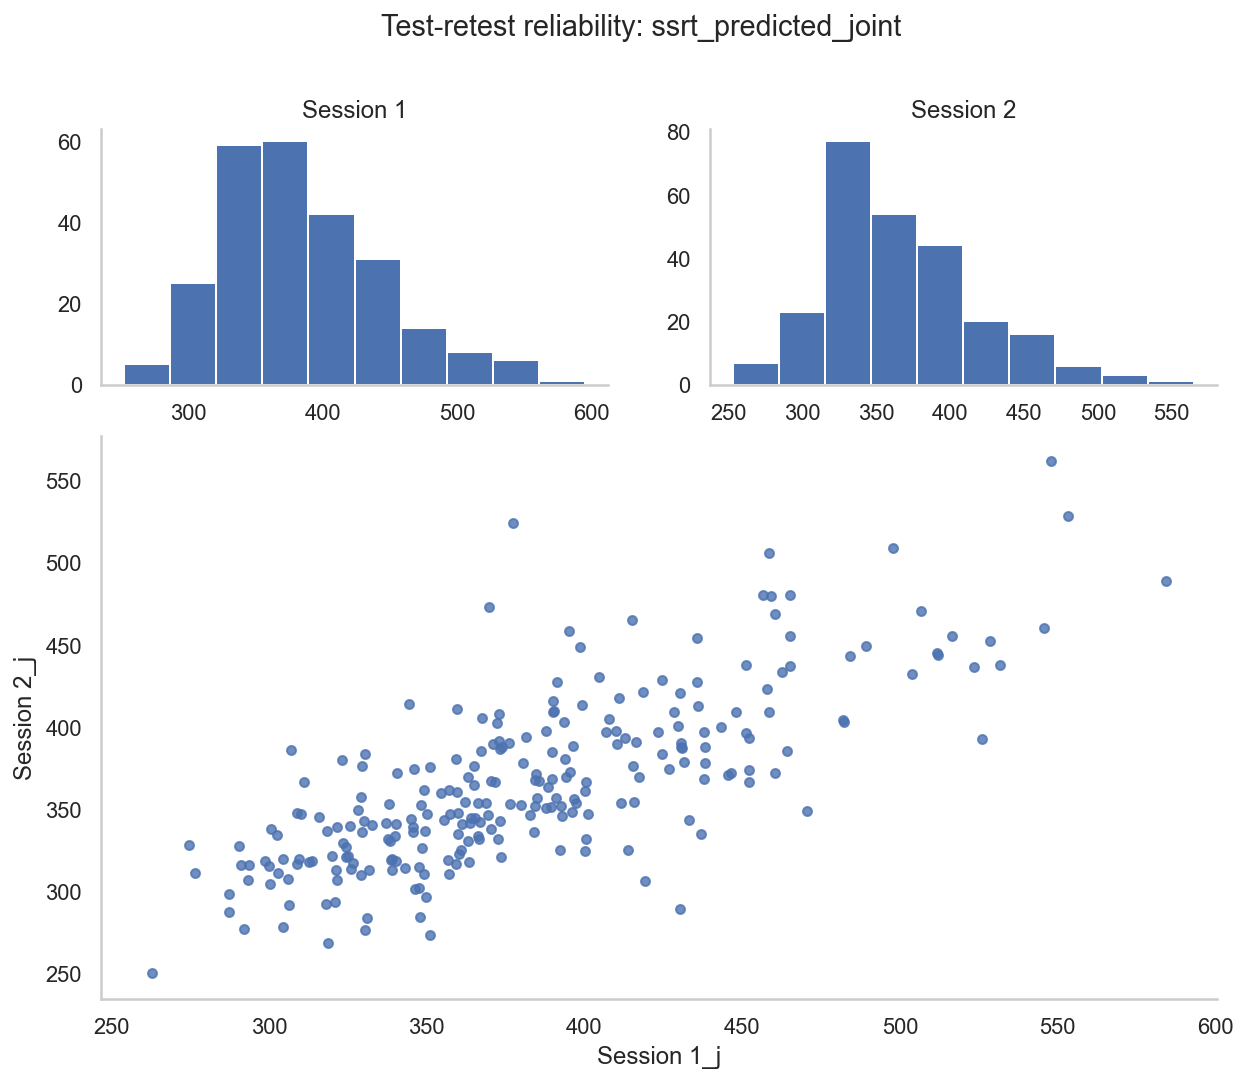

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
0,ICC1,0.810,18.040,250.0,753.0,0.0,0.781,0.837,".81 (.78, .84)"
1,ICC2,0.811,21.164,250.0,750.0,0.0,0.765,0.848,".81 (.77, .85)"
2,ICC3,0.834,21.164,250.0,750.0,0.0,0.809,0.858,".83 (.81, .86)"
3,ICC1k,0.945,18.040,250.0,753.0,0.0,0.935,0.953,".94 (.93, .95)"
4,ICC2k,0.945,21.164,250.0,750.0,0.0,0.929,0.957,".95 (.93, .96)"
5,ICC3k,0.953,21.164,250.0,750.0,0.0,0.944,0.960,".95 (.94, .96)"


,type,variance,Percent
0,Participant,2615.659,0.811
1,Session,89.848,0.028
2,Residual,518.877,0.161
3,Total,3224.384,1.000


In [ ]:
stats = reload(stats)
iccs_mean = stats.analyze_reliability(get_session_data(), "ssrt_predicted_joint", add_jitter = True)

Reliability is good to excellent.

#### Based on model variances
Question: Why do we call session variance residual variance in this formula?

In [ ]:
def get_model_calculated_icc(m):
    %R require(insight) -i m
    %R var_sess <- get_variance_intercept(m)[1]
    %R var_pp <- get_variance_intercept(m)[2]
    %R icc <- var_pp / (var_pp+(var_sess)) -o icc -o var_sess -o var_pp
    # Note that what get_variance_intercept outputs as session variance, we call residual, here
    variances = pd.DataFrame({"type":["Participant","Session","Residual"],"variance":[var_pp[0],0,var_sess[0]]})
    variances["Percent"] = variances.variance/variances.variance.sum()
    variances = {'iccs':[None, variances]}
    return {'icc':icc[0],'variances':variances}

def model_calculated_joint_icc():
    df = sst_data_getter()[['participant','baseline_session','gbe_baseline_index','is_stop','ssd','rt','omission','comission']]
    df['ssd_rt'] = (df['ssd']).fillna((df.query("is_stop==0").rt))
    df['session'] = df.baseline_session.apply(lambda x: int(x.split(' ')[1]))

    %R m = lmer(ssd_rt ~ 1 + (1 + is_stop | participant / session), data=df, na.action = na.exclude) -i df -o m
    print(get_model_calculated_icc(m))
    
model_calculated_joint_icc()
#model_calculated_iccs = {}
#model_calculated_iccs['oversampling_trial_joint'] = get_model_calculated_icc(models['oversampling_trial_joint'])
#model_calculated_iccs['oversampling_trial_joint']['icc']

R[write to console]: Loading required package: insight



{'icc': 0.8821512639892324, 'variances': {'iccs': [None,           type    variance   Percent
0  Participant  2333.50383  0.882151
1      Session     0.00000  0.000000
2     Residual   311.73846  0.117849]}}


In [ ]:
model_calculated_iccs['perc_gamble_trial_joint_mixed'] = get_model_calculated_icc(models['perc_gamble_trial_joint_mixed'])
model_calculated_iccs['perc_gamble_trial_joint_mixed']['icc']

0.7861487175988547

# Comparison of methods

## Internal consistency

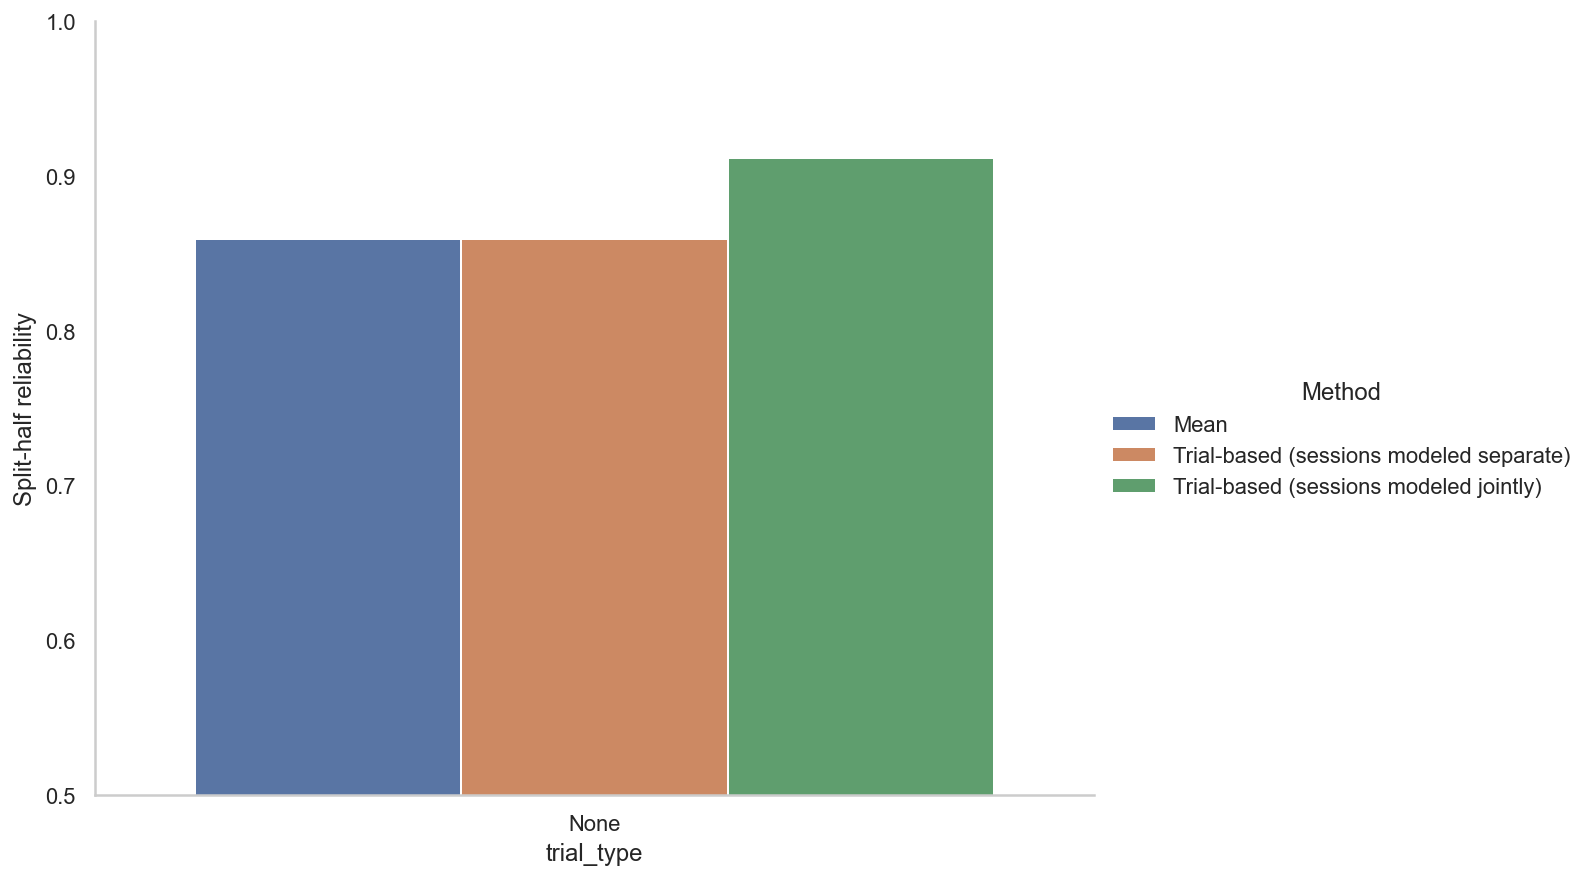

In [ ]:
df = pd.DataFrame({})
df.loc['mean_1','sb'] = os_mean['spearman_browns'][0]
df.loc['mean_2','sb'] = os_mean['spearman_browns'][1]
df.loc['trial_sep_1','sb'] =   os_trial_sep['spearman_browns'][0]
df.loc['trial_sep_2','sb'] =   os_trial_sep['spearman_browns'][1]
df.loc['trial_joint_1','sb'] =   os_trial_joint['spearman_browns'][0]
df.loc['trial_joint_2','sb'] =   os_trial_joint['spearman_browns'][1]


df = df.reset_index()
df.rename(columns = {'index':'category','sb':'Split-half reliability'}, inplace = True)
df['session'] = df.category.apply(lambda x: x.split('_')[-1])
df['trial_type'] = "None"
df['Method'] = df.category.apply(lambda x: '_'.join(x.split('_')[:-1]))
df.Method.replace({'mean':'Mean',
                  'trial_sep':'Trial-based (sessions modeled separate)',
                  'trial_joint':'Trial-based (sessions modeled jointly)'
                  }, inplace = True)


g = sns.catplot(x = "trial_type",       # x variable name
            y = "Split-half reliability",       # y variable name
            hue = "Method",  # group variable name
            data = df,     # dataframe to plot
            kind = "bar",
           ci = None,
            height=6, aspect=1.3)
g.set(ylim=(.5, 1))
ax = g.axes[0][0]
#ax.axhline(.8, color = 'black')

Questions:
- Do the improved split-half reliabilities indicate that the joint method indeed decreases measurement error?

## Test-retest reliability

In [ ]:
model_calculated_iccs['oversampling_trial_joint']['icc']

0.9205893162469

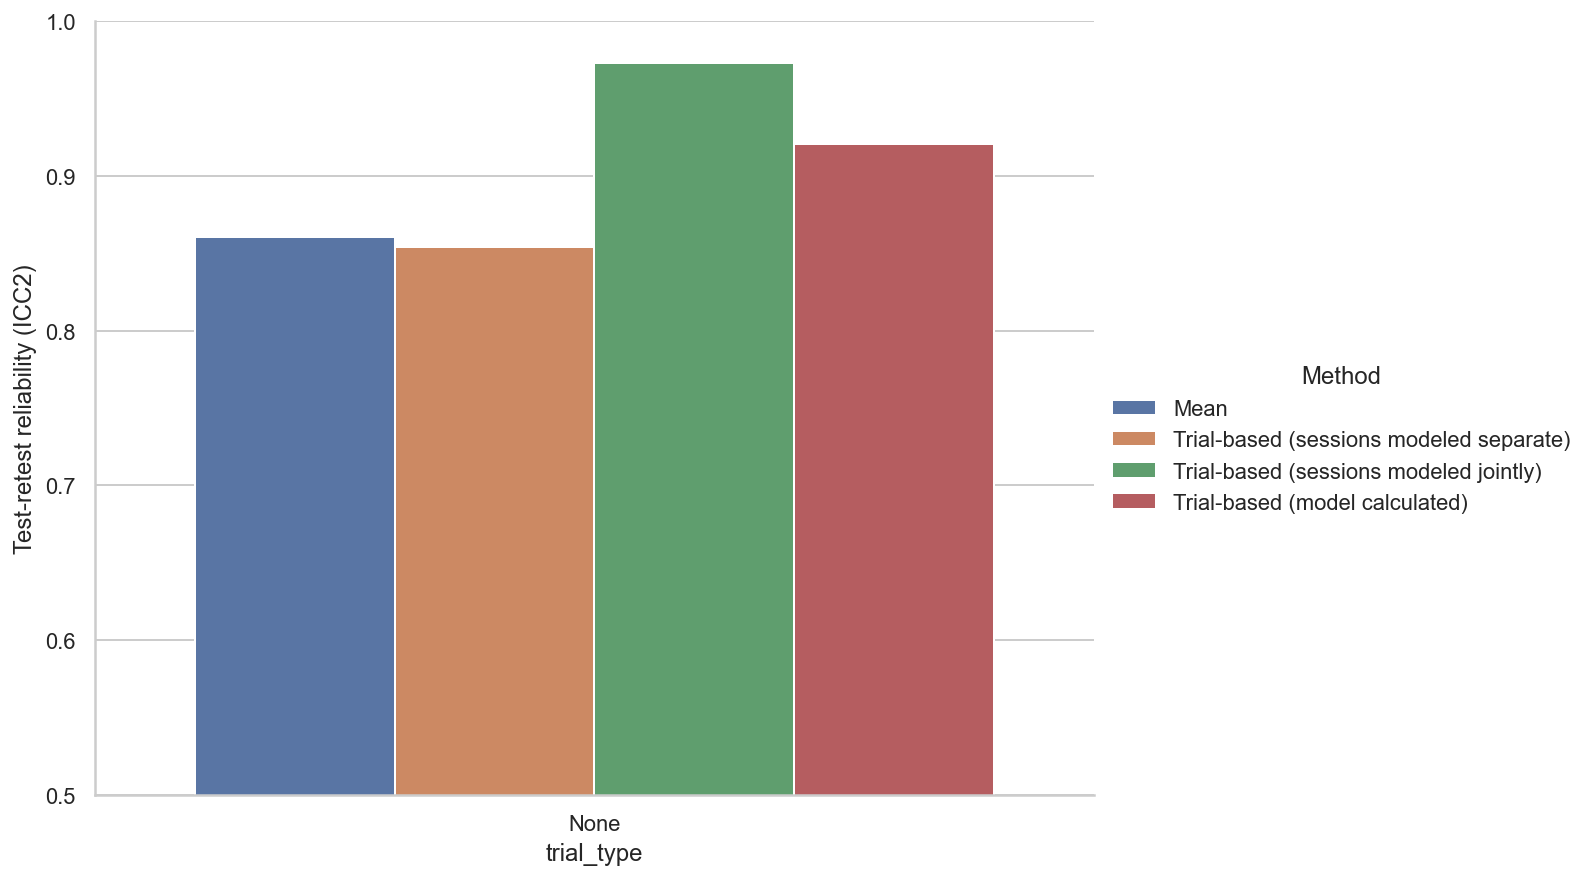

In [ ]:
df = pd.DataFrame({})
icc = "ICC2"#'ICC1k'
df.loc['mean','sb'] =                 iccs_mean['iccs'][0].query('type=="%s"'%icc)['ICC'].iloc[0]
df.loc['trial_sep','sb'] =       iccs_trial_sep['iccs'][0].query('type=="%s"'%icc)['ICC'].iloc[0]
df.loc['trial_joint','sb'] =   iccs_trial_joint['iccs'][0].query('type=="%s"'%icc)['ICC'].iloc[0]
df.loc['model_calc','sb'] =   model_calculated_iccs['oversampling_trial_joint']['icc']

df = df.reset_index()
df.rename(columns = {'index':'category','sb':"Test-retest reliability (%s)"%icc}, inplace = True)
df['trial_type'] = "None"#df.category.apply(lambda x: x.split('_')[-1])
df['Method'] = df.category.apply(lambda x: '_'.join(x.split('_')[:]))
df.Method.replace({'mean':'Mean',
                  'trial_sep':'Trial-based (sessions modeled separate)',
                  'trial_joint':'Trial-based (sessions modeled jointly)',
                  'model_calc':'Trial-based (model calculated)'
                  }, inplace = True)

g = sns.catplot(x = "trial_type",       # x variable name
            y = "Test-retest reliability (%s)"%icc,       # y variable name
            hue = "Method",  # group variable name
            data = df,     # dataframe to plot
            kind = "bar",
           ci = None,
            height=6, aspect=1.3)
g.set(ylim=(.5, 1))
ax = g.axes[0][0]
#ax.axhline(.8, color = 'black')

Questions:
- Is the joint model method mathematically similar to ICC(k)s?
  - Perhaps not, this method even improves upon ICC(k)s.
- Is the joint method reducing measurement error or predictable temporal variation?
- Make variance component plots

ToDo:
- Implement Vanessa Brown's Method (This should slightly reduce ICC's)
  - Add this as extra bar in the plot
- Explain Stein's paradox:
  - Usually, the average of past events is the best estimator of future events.
  - According to Stein's paradox, shrinking individual averages (e.g. session averages) towards grand averages (e.g., participant/sample averages) actually improves the prediction based on individual averages.
- Show how the different variances components of the ICCs change between the different methods
- Run unified model with all trial types
  - Perhaps as extra nesting 
- Add error-bars

# Variance components

In [ ]:
def var_comp_plot(title, results):
    perc_variance = []
    for r in results.items():
        perc_variance.append(r[1]['iccs'][1].set_index('type').T[['Participant','Session','Residual']].loc['Percent'])
    df = pd.DataFrame(perc_variance)
    df.index = results.keys()
    ax = df.plot(kind = 'bar', stacked = True)
    ax.grid(False)
    sns.despine()
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.12, 1.05))
    plt.xticks(rotation=0)

## Oversampling

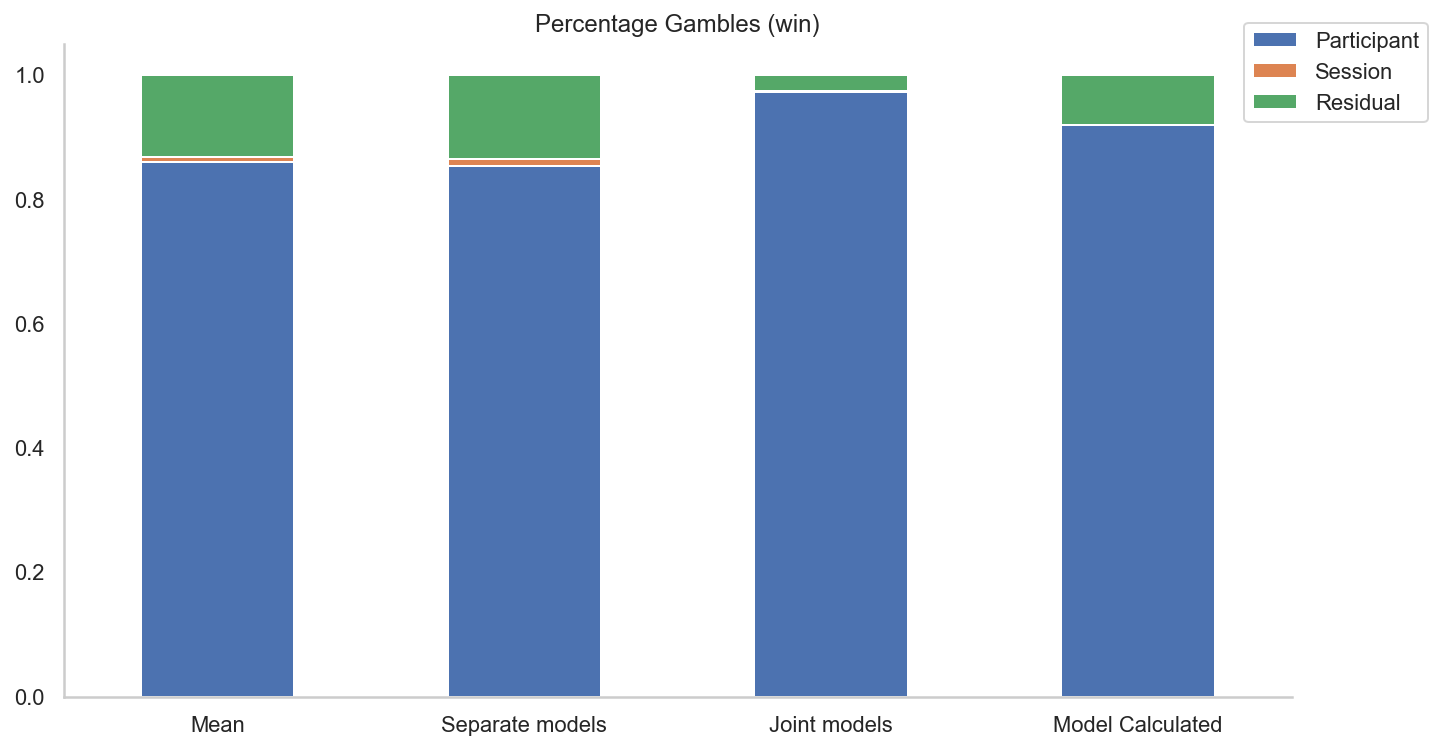

In [ ]:
var_comp_plot("Percentage Gambles (win)",{'Mean':iccs_mean,'Separate models':iccs_trial_sep,'Joint models':iccs_trial_joint,'Model Calculated':model_calculated_iccs['oversampling_trial_joint']['variances']})

Orange bar should be systematic session variance (double check).

# Explorations

## Model different trial types in same model